In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
from surprise import NormalPredictor
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from matplotlib.ticker import PercentFormatter
import random
from surprise.model_selection import GridSearchCV

<IPython.core.display.Javascript object>

# Introduction

In this NoteBook, I will use the Netflix dataset (https://www.kaggle.com/netflix-inc/netflix-prize-data) to create a recommender system. The goal of this project is to provide the top k movies for a specific user.

We will use a method called Collaborative Filtering which, in simple word, use the ratings of similar users to predict the rating of a user. More especially, we will use the SVD (Single Value Decomposition) algorithm because it's an efficient one and it's still used a lot.

Let's first start by importing our data and having a quick look at them.

In [3]:
title = pd.read_csv(
    r"D:/git/collaborative_filtering/recommender_system/data/movie_titles.csv",
    header=None,
    encoding="ISO-8859-1",
    usecols=[0, 1, 2],
    names=["movie_id", "year", "name"],
)
df = pd.read_csv(
    "D:/git/collaborative_filtering/recommender_system/data/combined_data_1.txt",
    header=None,
    names=["user_id", "rating", "timestamp"],
)

<IPython.core.display.Javascript object>

In [4]:
title.head()

,movie_id,year,name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


<IPython.core.display.Javascript object>

In [5]:
df.head()

,user_id,rating,timestamp
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26


<IPython.core.display.Javascript object>

# Data preprocessing

The dataset are not ready to be used for our SVD algorithm, we first need to transform our dataset from this form:

    movie_id | Nan    | Nan
    user_id  | rating | timestamp
                 ...

To the following:

    user_id | rating | timestamp | movie_id

In [6]:
# create a df with only the movie_id and the number of reviews per movie
df_nan = pd.DataFrame(pd.isnull(df["rating"]))
df_nan["movie_id"] = df["user_id"].map(lambda x: x.rstrip(":")).astype(int)
df_nan = df_nan[df_nan["rating"] == True]
df_nan = df_nan.reset_index()

movie_np = []

# take the difference between the number of ratings of a row and the previous one and add it with the corresponing movie_id
for i, j, k in zip(df_nan["index"][1:], df_nan["index"][:-1], df_nan["movie_id"]):
    temp = np.full((1, i - j - 1), k)
    movie_np = np.append(movie_np, temp)

# Account for last record and corresponding length
last_record = np.full((1, len(df) - df_nan.iloc[-1, 0] - 1), df_nan.iloc[-1, 2])
movie_np = np.append(movie_np, last_record)

<IPython.core.display.Javascript object>

Before adding the movie_id to the dataset, let's check if they have the same size.

In [7]:
# check if they have the same size
print(len(movie_np) - len(df))

-4499


<IPython.core.display.Javascript object>

We can see that our original dataframe and our movie id array have different size. The reason is there is still the movie id row in the original df so we need to get ride of them.

In [8]:
df = df.loc[pd.isnull(df["rating"]) == False]
print(len(movie_np) - len(df))

0


<IPython.core.display.Javascript object>

We now have the same size for the original dataset and our movie_id array. We can add the movie ids to our dataset. 

In [9]:
df["movie_id"] = movie_np.astype(int)
df.head()

,user_id,rating,timestamp,movie_id
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
5,823519,3.0,2004-05-03,1


<IPython.core.display.Javascript object>

# Data Exploration

In this section, we will explore a bit our data to understand it better. We will also check if we need to remove some data.

Let's start with ploting the distribution of our ratings.

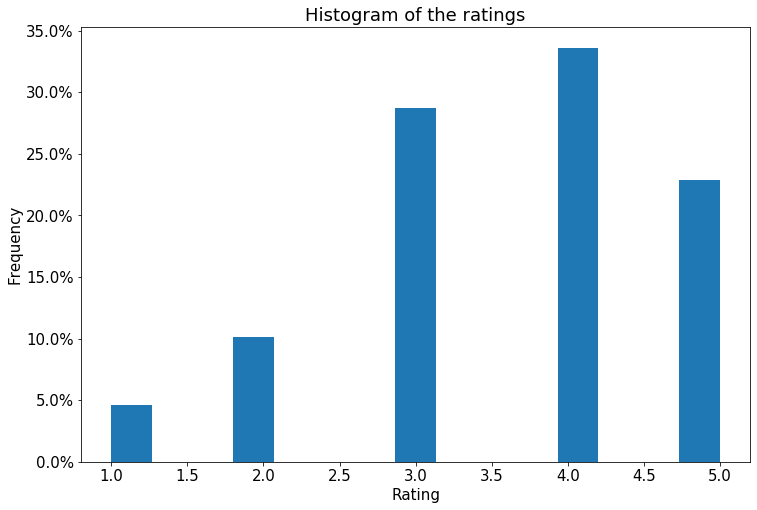

<IPython.core.display.Javascript object>

In [10]:
plt.rcParams.update({"font.size": 15})
plt.figure(figsize=(12, 8))
plt.hist(df["rating"], weights=np.ones(len(df["rating"])) / len(df["rating"]), bins=15)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Histogram of the ratings")
plt.show()

We can see that most of the ratings are mostly positive (equal or superior at 3).

A common problem in recommendation systems is that most of the ratings are concentred on a few number of popular movies. To illustrate that let's check how the 30% of our most voted movies weight on the whole dataset.

In [11]:
movier_count = (
    df[["movie_id", "rating"]].groupby(["movie_id"], as_index=False).agg(["count"])
)
movier_count.columns = list(map("_".join, movier_count.columns.values))
popular_movies = movier_count.sort_values(by="rating_count", ascending=False)
popular_movies = popular_movies.loc[
    popular_movies["rating_count"] >= popular_movies["rating_count"].quantile(0.70)
]

perc = (popular_movies["rating_count"].sum() / movier_count["rating_count"].sum()) * 100

print(
    "The 30% most popular movies represent {}% of our total ratings".format(
        round(perc, 2)
    )
)

The 30% most popular movies represent 94.08% of our total ratings


<IPython.core.display.Javascript object>

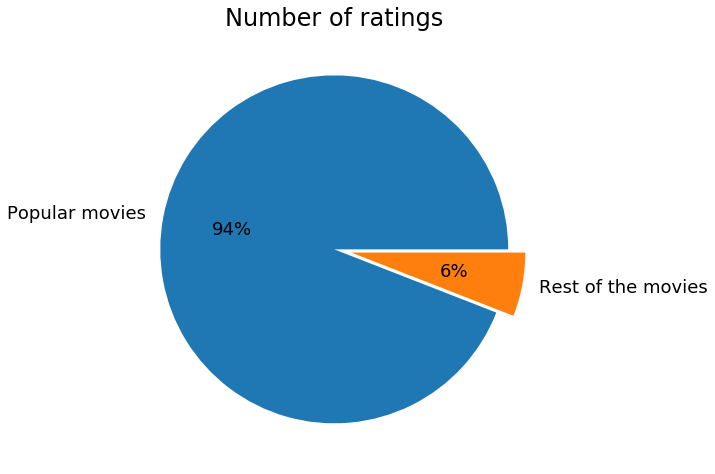

<IPython.core.display.Javascript object>

In [12]:
x = [
    popular_movies["rating_count"].sum(),
    movier_count["rating_count"].sum() - popular_movies["rating_count"].sum(),
]

plt.figure(figsize=(12, 8))
plt.rcParams.update({"font.size": 18})
plt.pie(
    x,
    labels=["Popular movies", "Rest of the movies"],
    autopct="%1.0f%%",
    explode=(0, 0.1),
)
plt.rcParams.update({"font.size": 20})

plt.title("Number of ratings")
plt.show()

So we can see that this problem is real, especially in our dataset. The problem with an unbalanced concentration is that the recommender will more likely recommend popular movie and won't recommend less popular movie even if this one is relevant.

# MODEL

In [13]:
# save the df
df.to_csv("D:/data/netflix/df.csv", index=False)

<IPython.core.display.Javascript object>

As my computer is not powerful enough, I will only use a subset of the data to train the recommender system. However, the process is the same regardless the size of the dataset you are using.

As we take a subset our the dataset, shuffling is important to have a variety of movie in the subset.

In [14]:
# taking only the first n rows
df = pd.read_csv("D:/data/netflix/df.csv")
from sklearn.utils import shuffle

df = shuffle(df).reset_index(drop=True)
df = df.iloc[:2000000]

df.head()

,user_id,rating,timestamp,movie_id
0,10779,5.0,2004-02-06,1639
1,1438997,4.0,2004-06-08,4472
2,1660482,3.0,2005-06-15,4384
3,148844,3.0,2005-01-20,3925
4,345035,4.0,2004-03-19,1035


<IPython.core.display.Javascript object>

## Training

To evualuate the performance of the model, we will use the RMSE. However, we will also calculate the MAE, Recall@k and Precision@k to have a better idea of the model performance. 

In [15]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls


<IPython.core.display.Javascript object>

We will search for the best hyperparameters by doing a grid search with cross validation on 90% of our dataset. The best parameters are:
- the number of latent factor that we will use to model the user preference / movie category.
- the learning rate
- the number of epoch

Then, we will evaluate the performance on the 10% remining to have an unbiased accuracy estimation.

In [16]:
# unbiased accuracy estimation

# Load the full dataset.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[["user_id", "movie_id", "rating"]], reader)
raw_ratings = data.raw_ratings

# shuffle
random.shuffle(raw_ratings)

# A = 90% of the data, B = 10% of the data
threshold = int(0.9 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

data.raw_ratings = A_raw_ratings  # data is now the set A

# Select your best algo with grid search.
print("Grid Search...")
param_grid = {
    "n_factors": [
        5,
        10,
    ],
    "n_epochs": [15, 20],
    "lr_all": [0.002, 0.005, 0.01],
}
grid_search = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=3)
grid_search.fit(data)

algo = grid_search.best_estimator["rmse"]

# retrain on the whole set A
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on A
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on A,", end="   ")
accuracy.rmse(predictions)
accuracy.mae(predictions)

precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)
print("Precision@k: ", sum(prec for prec in precisions.values()) / len(precisions))
print("Recall@k: ", sum(rec for rec in recalls.values()) / len(recalls))

# Compute unbiased accuracy on B
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
predictions = algo.test(testset)
print("Unbiased accuracy on B,", end=" ")
accuracy.rmse(predictions)
accuracy.mae(predictions)

precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)
print("Precision@k: ", sum(prec for prec in precisions.values()) / len(precisions))
print("Recall@k: ", sum(rec for rec in recalls.values()) / len(recalls))

# see the best params based on the RMSE
grid_search.best_params["rmse"]

Grid Search...
Biased accuracy on A,   RMSE: 0.8761
MAE:  0.6934
Precision@k:  0.45722225494530766
Recall@k:  0.2747128651163116
Unbiased accuracy on B, RMSE: 0.9660
MAE:  0.7644
Precision@k:  0.23940734781442763
Recall@k:  0.21433702701685753


{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005}

<IPython.core.display.Javascript object>

Our best model has an **accurancy (RMSE) of 0.9660 on the test set** and a **MAE of 0.7644 on the test set** . It's normal that the RMSE is higher than the MEA because it's more sensitive to high error.

Globally, we can say that our model has a good performance. To understand it better, let's check the recall@k and precision@k.

Let's now have a look at the recall@k and the precision@k.

The **recall@k is 21.55%** in our test dataset which means that 21.55% of the known relevant item (with a rating superior at 3.5) appear in our top-10 recommendations.

The **precision@k is 24.08%** in our test dataset which means that 24.08% of the movies recommended are actually relevant for the users.

It's important to notice that the performance is limited by the reduced size of the dataset. 

It's also interesting to look at the number of latent vector we have. In our case, the best model has 5 latent vectors which means that we can regroup our movie categories into 5 different ones.

## Prediction (make recommendations for one user)

Now that we found the best hyperparamers, we can train the model on the full dataset and make n recommendation for a specific user with the following function.

In [17]:
def make_recommendation(user_id, n, algo):
    """ Return the n best recommendation for a specific user_id"""

    reco = title.copy().reset_index(drop=True)
    reco["predicted_score"] = reco["movie_id"].apply(
        lambda x: algo.predict(user_id, x).est
    )
    reco = reco.sort_values("predicted_score", ascending=False)
    return reco.iloc[:n].reset_index(drop=True)


# the best hyperparameters found in the previous step
best_params = grid_search.best_params["rmse"]

# build the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[["user_id", "movie_id", "rating"]], reader)
data = data.build_full_trainset()
algo = SVD(**best_params)  # retrain with the best parameters
algo.fit(data)

<IPython.core.display.Javascript object>

In [18]:
# make recommendation for specific user
make_recommendation(298972, 10, algo)

,movie_id,year,name,predicted_score
0,3456,2004.0,Lost: Season 1,4.629791
1,2803,1995.0,Pride and Prejudice,4.526815
2,2102,1994.0,The Simpsons: Season 6,4.525478
3,4427,2001.0,The West Wing: Season 3,4.509857
4,4238,2000.0,Inu-Yasha,4.508027
5,3444,2004.0,Family Guy: Freakin' Sweet Collection,4.500545
6,3290,1974.0,The Godfather,4.498278
7,724,1992.0,Yu Yu Hakusho,4.493093
8,1947,2002.0,Gilmore Girls: Season 3,4.473773
9,2568,2004.0,Stargate SG-1: Season 8,4.466121


<IPython.core.display.Javascript object>

Now let's have a look human look at our recommendations: the movies/tv shows recommended looks alike so it looks like our recommender works well.

## Prediction (all users)

Now, we want to predict the ratings for the all the pair user / item without ratings. 

This part doesn't work with the dataset we used previously because it is too expansive in memory. However, the procedure should work on a more powerful computer.

We will still do it a small subset of our data.

In [19]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

<IPython.core.display.Javascript object>

In [20]:
# the best hyperparameters found in the previous step
best_params = grid_search.best_params["rmse"]

# build the dataset with a few observations
reader = Reader(rating_scale=(1, 5))
small_df = df[["user_id", "movie_id", "rating"]].iloc[:10000]  # take 10000 observations
data = Dataset.load_from_df(small_df, reader)
data = data.build_full_trainset()

# Than predict ratings for all pairs (u, i) that are not in the training set.

testset = data.build_anti_testset()  # we used the model we trained in the previous step
predictions = algo.test(testset)
top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
top_n_list = []
for uid, user_ratings in top_n.items():
    top_n_list.append([uid, [iid for (iid, _) in user_ratings]])
pd.DataFrame(top_n_list, columns=["user_id", "recommendations"]).head()

,user_id,recommendations
0,10779,"[3290, 2172, 2102, 3962, 2162, 2548, 2057, 423..."
1,1438997,"[2803, 3456, 270, 2102, 1476, 4427, 3290, 4238..."
2,1660482,"[3456, 2803, 2102, 270, 4238, 2114, 3290, 1947..."
3,148844,"[3456, 4427, 3444, 2102, 3962, 4238, 2568, 194..."
4,345035,"[3456, 2803, 270, 2102, 2114, 1476, 3962, 4427..."


<IPython.core.display.Javascript object>

To finish our analysis, let's check one last metrics: the coverage. As we said earlier, when most of ratings are concentred into a small number of movies, the recommender system will more likely recommend those movies and the number of different recommended movies  will be small.

To measure this problem, we can use the coverage, which is the percentage of the training movies recommended in the test set. 


In [21]:
# list of the recommended items
top_list = []
for uid, user_ratings in top_n.items():
    top_list.append([iid for (iid, _) in user_ratings])
flat_list = [item for sublist in top_list for item in sublist]
# count the unique values
coverage = len(set(flat_list)) / len(small_df["movie_id"].unique()) * 100
print("The coverage is {}%".format(round(coverage, 2)))

The coverage is 5.75%


<IPython.core.display.Javascript object>

We have a coverage of 5.75% which means that only 5.75% of our movies (of the small dataset) are recommended. This score shows the problem we talked earlier with having an unbalanced amount of ratings by movie. 

And this finish our work on this recommender system. 

So we see that SVD is a solid method to build a recommender system. Based on the metrics, the model is performing well and based on our human interpretation, it looks like the recommended items make sense. However, we saw that the coverage rate is a bit low. 

This problem can be adresse by changing the model: some model have shown good results in improving the coverage rate like context based model or reinforcement learning.